特徴量抽出の過程。今回は4つの分類器を使って行った。分類器のパラメータはnormal_tuningでスコアがベストだったものを選んでいる。以下は各コードの概要

1. データの前処理、サンプリング
2. 必要な機械学習のライブラリをインポート
3. DecisionTreeを使って特徴量の重要度を計算
4. RandomForestを使って特徴量の重要度を計算
5. AdaBoostを使って特徴量の重要度を計算
6. GradientBoostを使って特徴量の重要度を計算
7. 4分類器の重要度の計算結果をdata frameにまとめ、平均重要度の平均を算出。重要度が高かったものを選ぶ
8. 抽出特徴量を1つのデータフレームにまとめる
9. 特徴量同士の相関表を求める
10. 顧客と特徴量（campaignとduration）についての関係を散布図にプロット
11. 顧客と特徴量（campaignとbalance）についての関係を散布図にプロット
12. 顧客と特徴量（balanceとduration）についての関係を散布図にプロット
13. 顧客年齢とcampaignの関係を散布図にプロット
14. 顧客年齢とdurationの関係を散布図にプロット
15. 顧客年齢とbalanceの関係を散布図にプロット

結論：散布図を通しで見ると、顧客との連絡を頻繁に、通話時間を長くするほど成約率が高いことが分かる。また口座残高の多寡は関係ないことが分かる。加えて、60代以上の顧客とは銀行が連絡をおろそかにしがちだが、実際は20～50代同様頻繁に連絡を取っても一定の成約が得られることが分かる。これらの推測が正しいかどうかは、特徴量抽出後のモデルの性能が高いかどうかで判断できるだろう。

In [1]:
#データの前処理・オーバーサンプリング
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
df=pd.read_csv("train.csv")
df_dummy=pd.get_dummies(df[["job","marital","education",
                            "default","housing","loan",
                            "contact","month","poutcome","subscribed",
                            "age","balance","day","previous",
                            "duration","campaign","pdays"]],drop_first=True)
X,y=df_dummy.iloc[:,0:42],df_dummy.iloc[:,42].values
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1,stratify=y)
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.fit_transform(X_test)
from imblearn import FunctionSampler
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve,roc_auc_score,roc_curve
from sklearn.metrics import recall_score, classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

 1)duration                      0.271485
 2)campaign                      0.086554
 3)balance                       0.080556
 4)age                           0.074405
 5)day                           0.066826
 6)housing_yes                   0.047579
 7)pdays                         0.029107
 8)marital_married               0.028268
 9)contact_unknown               0.027398
10)marital_single                0.025224
11)previous                      0.023190
12)month_may                     0.022630
13)job_blue-collar               0.019055
14)loan_yes                      0.018296
15)poutcome_success              0.016728
16)education_tertiary            0.015976
17)education_secondary           0.013071
18)month_sep                     0.012415
19)month_aug                     0.011087
20)job_management                0.011076
21)job_technician                0.010163
22)contact_telephone             0.008906
23)month_nov                     0.008195
24)month_jul                     0

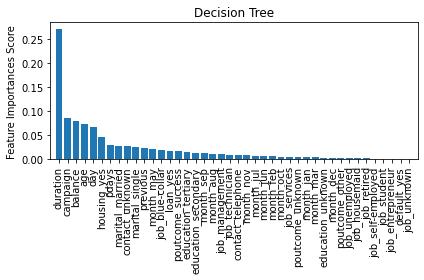

In [ ]:
#決定木で重要度を抽出
feat_label=df_dummy.columns[0:]
tree=DecisionTreeClassifier(random_state=1,
                            criterion="entropy",
                            max_depth=None,
                            max_features="log2")
tree.fit(X_train_res,y_train_res)
importances_tree=tree.feature_importances_
indices=np.argsort(importances_tree)[::-1]
for f in range(X_train_res.shape[1]):
    print("%2d)%-*s%f"%
        (f+1,30,feat_label[indices[f]],importances_tree[indices[f]]))
plt.title("Decision Tree")
plt.bar(range(X_train_res.shape[1]),importances_tree[indices],align="center")
plt.xticks(range(X_train_res.shape[1]),feat_label[indices],rotation=90)
plt.xlim([-1,X_train_res.shape[1]])
plt.ylabel("Feature Importances Score")
plt.tight_layout()
plt.show()

#1)duration                      0.424711
#2)contact_unknown               0.127017
#3)housing_yes                   0.115248
#4)loan_yes                      0.067946
#5)pdays                         0.047491

 1)duration                      0.278747
 2)campaign                      0.083890
 3)balance                       0.069939
 4)housing_yes                   0.065666
 5)day                           0.060905
 6)age                           0.057801
 7)contact_unknown               0.040871
 8)poutcome_success              0.026937
 9)marital_married               0.025340
10)pdays                         0.025186
11)previous                      0.022152
12)loan_yes                      0.021358
13)month_may                     0.020046
14)education_secondary           0.019477
15)marital_single                0.015382
16)education_tertiary            0.013555
17)job_blue-collar               0.013126
18)month_jul                     0.012567
19)month_aug                     0.012227
20)poutcome_unknown              0.011805
21)job_management                0.009689
22)job_technician                0.009478
23)month_nov                     0.008721
24)month_jun                     0

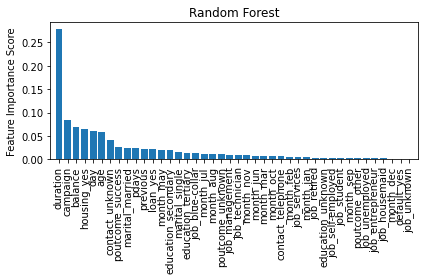

In [ ]:
#ランダムフォレストで重要特徴量抽出
feat_label=df_dummy.columns[0:]
forest=RandomForestClassifier(random_state=1,
                              criterion="entropy",
                              max_depth=None,
                              max_features="log2",
                              n_estimators=200)
forest.fit(X_train_res,y_train_res)
importances_rfc=forest.feature_importances_
indices=np.argsort(importances_rfc)[::-1]
for f in range(X_train_res.shape[1]):
    print("%2d)%-*s%f"%
        (f+1,30,feat_label[indices[f]],importances_rfc[indices[f]]))

plt.title("Random Forest")
plt.bar(range(X_train_res.shape[1]),importances_rfc[indices],align="center")
plt.xticks(range(X_train_res.shape[1]),feat_label[indices],rotation=90)
plt.xlim([-1,X_train_res.shape[1]])
plt.ylabel('Feature Importance Score')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 1)duration                      0.213523
 2)campaign                      0.199720
 3)housing_yes                   0.069613
 4)balance                       0.066806
 5)age                           0.065499
 6)day                           0.063855
 7)contact_unknown               0.039384
 8)marital_married               0.025687
 9)poutcome_unknown              0.023158
10)loan_yes                      0.021580
11)marital_single                0.016742
12)education_secondary           0.014885
13)poutcome_success              0.014046
14)month_jul                     0.013365
15)pdays                         0.012726
16)job_blue-collar               0.012089
17)education_tertiary            0.010745
18)previous                      0.010392
19)month_aug                     0.010022
20)month_may                     0.010018
21)job_management                0.008233
22)job_technician                0.008057
23)month_mar                     0.006883
24)month_nov                     0

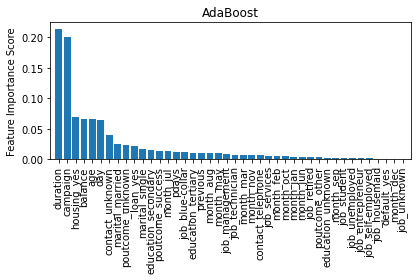

In [ ]:
#adaboostで特徴量抽出
feat_label=df_dummy.columns[0:]
ada_dt=DecisionTreeClassifier(random_state=1,
                               criterion="entropy",
                               max_depth=None,
                               max_features="log2")
ada=AdaBoostClassifier(base_estimator=ada_dt,
                       learning_rate=0.01,
                       n_estimators=50)
ada.fit(X_train_res,y_train_res)
importances_ada=ada.feature_importances_
indices=np.argsort(importances_ada)[::-1]
for f in range(X_train_res.shape[1]):
    print("%2d)%-*s%f"%
        (f+1,30,feat_label[indices[f]],importances_ada[indices[f]]))

plt.title("AdaBoost")
plt.bar(range(X_train_res.shape[1]),importances_ada[indices],align="center")
plt.xticks(range(X_train_res.shape[1]),feat_label[indices],rotation=90)
plt.xlim([-1,X_train_res.shape[1]])
plt.ylabel('Feature Importance Score')
plt.tight_layout()
plt.show()

 1)duration                      0.430118
 2)campaign                      0.086445
 3)housing_yes                   0.077058
 4)contact_unknown               0.067068
 5)poutcome_success              0.060605
 6)day                           0.039003
 7)balance                       0.036651
 8)age                           0.031779
 9)loan_yes                      0.015623
10)month_mar                     0.015459
11)pdays                         0.013954
12)month_oct                     0.013477
13)previous                      0.011312
14)month_may                     0.010245
15)month_jul                     0.009545
16)month_aug                     0.009295
17)marital_married               0.008255
18)job_blue-collar               0.007135
19)month_nov                     0.006181
20)month_jun                     0.005873
21)education_secondary           0.005672
22)month_feb                     0.004480
23)marital_single                0.003828
24)education_tertiary            0

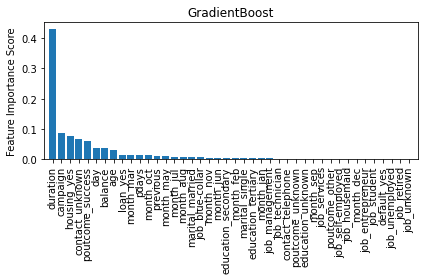

In [ ]:
#gradientboost で特徴量抽出
feat_label=df_dummy.columns[0:]
gb=GradientBoostingClassifier(max_depth=9,
                              random_state=1,
                              learning_rate=0.1,
                              n_estimators=100)
gb.fit(X_train_res,y_train_res)
importances_gb=gb.feature_importances_
indices=np.argsort(importances_gb)[::-1]
for f in range(X_train_res.shape[1]):
    print("%2d)%-*s%f"%
        (f+1,30,feat_label[indices[f]],importances_gb[indices[f]]))

plt.title("GradientBoost")
plt.bar(range(X_train_res.shape[1]),importances_gb[indices],align="center")
plt.xticks(range(X_train_res.shape[1]),feat_label[indices],rotation=90)
plt.xlim([-1,X_train_res.shape[1]])
plt.ylabel('Feature Importance Score')
plt.tight_layout()
plt.show()

In [ ]:
#重要度をデータフレームにまとめて、各分類器の重要度スコアの計算を行う
#重要度が高い物上位から選ぶ
from tables.table import Description
column_df=pd.DataFrame()
column_df["DecisionTree"]=importances_tree[indices]
column_df["RandomForest"]=importances_rfc[indices]
column_df["AdaBoost"]=importances_ada[indices]
column_df["GradientBoost"]=importances_gb[indices]
column_df["best_feat"]=(column_df["DecisionTree"]+column_df["RandomForest"]+column_df["AdaBoost"]+column_df["GradientBoost"])/4
column_df["feat_label"]=feat_label[indices]
column_df.sort_values("best_feat", ascending=False)
#訂正後：duration,campaign,balance,day,housing_yes,age

,DecisionTree,RandomForest,AdaBoost,GradientBoost,best_feat,feat_label
0,0.271485,0.278747,0.213523,0.430118,0.298468,duration
1,0.086554,0.083890,0.199720,0.086445,0.114152,campaign
2,0.047579,0.065666,0.069613,0.077058,0.064979,housing_yes
6,0.080556,0.069939,0.066806,0.036651,0.063488,balance
5,0.066826,0.060905,0.063855,0.039003,0.057647,day
7,0.074405,0.057801,0.065499,0.031779,0.057371,age
3,0.027398,0.040871,0.039384,0.067068,0.043680,contact_unknown
4,0.016728,0.026937,0.014046,0.060605,0.029579,poutcome_success
16,0.028268,0.025340,0.025687,0.008255,0.021888,marital_married
10,0.029107,0.025186,0.012726,0.013954,0.020243,pdays


In [4]:
df_6=pd.DataFrame()
df_6["duration"]=df_dummy["duration"]
df_6["campaign"]=df_dummy["campaign"]
df_6["balance"]=df_dummy["balance"]
df_6["day"]=df_dummy["day"]
df_6["housing_yes"]=df_dummy["housing_yes"]
df_6["age"]=df_dummy["age"]
df_6["subscribed_yes"]=df_dummy["subscribed_yes"]

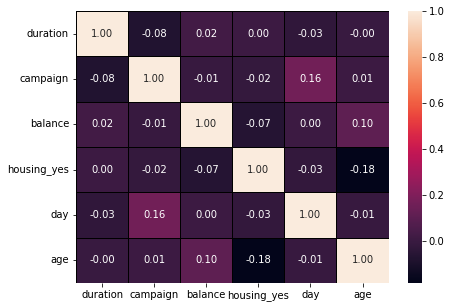

In [5]:
#抽出特徴量同士の相関表を出した。
#相関の強いものがなかったので、モデルには多重共線性がないこと、過学習や学習不足がないことが分かる。
import seaborn as sns
f,ax=plt.subplots(figsize=(7,5))
sns.heatmap(df_6[["duration","campaign","balance","housing_yes","day","age"]].corr(),annot=True,linewidths=0.5,linecolor="black",fmt=".2f",ax=ax)
plt.show()

In [7]:
import plotly.express as px
fig = px.scatter(df_6,x="campaign", y="duration",color="subscribed_yes")
fig.show()
#campaign,duraionの関係の確認

In [9]:
fig = px.scatter(df_6,x="campaign", y="balance",color="subscribed_yes")
fig.show()
#campaign,balanceの関係の確認

In [11]:
#duration,balanceの関係確認
fig = px.scatter(df_6,x="duration", y="balance",color="subscribed_yes")
fig.show()

In [70]:
import plotly.express as px
fig = px.scatter(df_6,x="age", y="campaign",color="subscribed_yes")
fig.show()
#年齢と顧客との連絡頻度の関係。高齢者には連絡していない傾向にあることが分かる。
#そもそも連絡の絶対数が少ない

In [67]:
import plotly.express as px
fig = px.scatter(df_6,x="age", y="duration",color="subscribed_yes")
fig.show()
#年齢と通話時間の関係
#銀行側が60代以上の顧客とは連絡をとっていない傾向にあることが分かる

In [68]:
import plotly.express as px
fig = px.scatter(df_6,x="age", y="balance",color="subscribed_yes")
fig.show()
#高齢なほど口座残高が低くなる傾向になる。
#それはあたりまえか……。